In [179]:
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

In [180]:
train = Path('./dataset/train')
train_filepaths = list(train.glob(r'**/*.jpg')) 

valid = Path('./dataset/validation')
valid_filepaths = list(valid.glob(r'**/*.jpg'))

test = Path('./dataset/test')
test_filepaths = list(test.glob(r'**/*.jpg'))

In [181]:
def process_img(filepath): 
    
    labels = [str(filepath[i]).split("/")[-2] 
              for i in range(len(filepath))] 
    
    filepath = pd.Series(filepath, name='FilePath').astype(str)
    labels = pd.Series(labels, name='Label') 
    
    df = pd.concat([filepath, labels], axis=1) 
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [182]:
train_df = process_img(train_filepaths) 
valid_df = process_img(valid_filepaths)
test_df = process_img(test_filepaths)

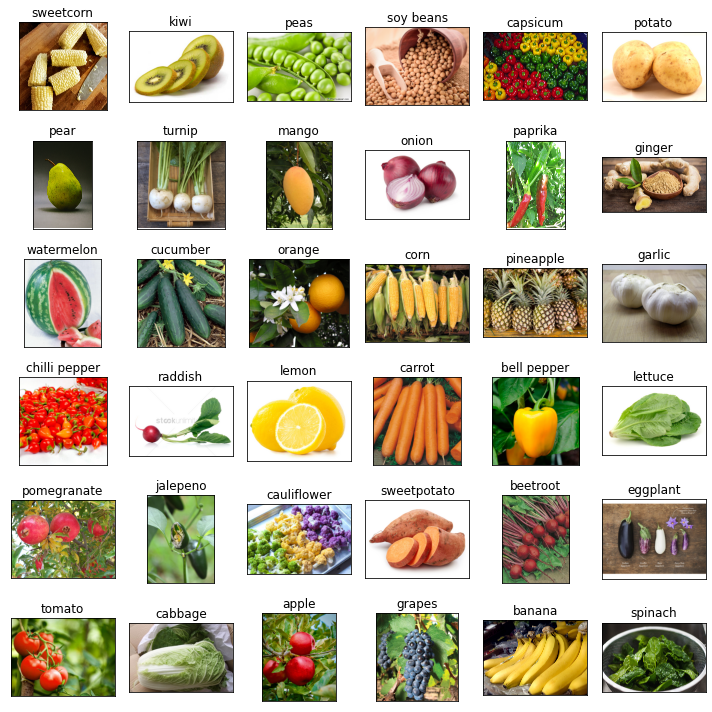

In [184]:
unique_labels = train_df.copy().drop_duplicates(subset=['Label']).reset_index() 

fig, axes = plt.subplots(6,6, figsize=(10,10),subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(unique_labels.FilePath[i]))
    ax.set_title(unique_labels.Label[i], fontsize=12)
    
plt.tight_layout()
plt.show()

In [185]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = data_gen.flow_from_dataframe(
    dataframe = train_df,
    x_col='FilePath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

valid_images = data_gen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='FilePath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = data_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='FilePath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [186]:
base_model =  tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg',
) 

base_model.trainable = False 

9406464/9406464 [==============================] - 8s 1us/step


In [187]:
base_model.summary() 

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [188]:
inputs = base_model.input

x = tf.keras.layers.Dense(128, activation='relu')(base_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x) 

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs) 

model.compile(                                          
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [213]:
history = model.fit(                 
    train_images,
    validation_data=valid_images,
    batch_size = 32,
    epochs=10,
    callbacks=[                   
        tf.keras.callbacks.EarlyStopping(  
            monitor='val_loss',
            patience=2,
            restore_best_weights=True 
        )
    ]
)
          

Epoch 1/10
87/87 [==============================] - 169s 2s/step - loss: 0.0945 - accuracy: 0.9694 - val_loss: 0.1703 - val_accuracy: 0.9521
Epoch 2/10
87/87 [==============================] - 157s 2s/step - loss: 0.0833 - accuracy: 0.9727 - val_loss: 0.1495 - val_accuracy: 0.9671
Epoch 3/10
87/87 [==============================] - 156s 2s/step - loss: 0.0519 - accuracy: 0.9845 - val_loss: 0.1537 - val_accuracy: 0.9731
Epoch 4/10
87/87 [==============================] - 157s 2s/step - loss: 0.0598 - accuracy: 0.9809 - val_loss: 0.1608 - val_accuracy: 0.9551


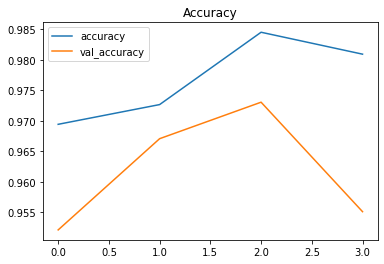

In [214]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()  
plt.title('Accuracy')
plt.show()


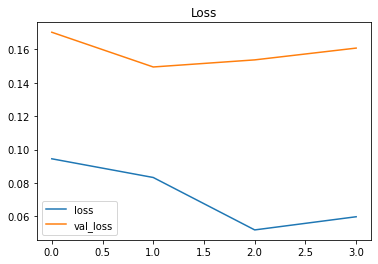

In [215]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Loss')
plt.show()

In [222]:
pred = model.predict(test_images) 
pred = np.argmax(pred, axis=1) 

11/11 [==============================] - 24s 2s/step


In [223]:
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items()) 
pred = [labels[k] for k in pred] 
y_test = [labels[k] for k in test_images.classes] 
from sklearn.metrics import accuracy_score 
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

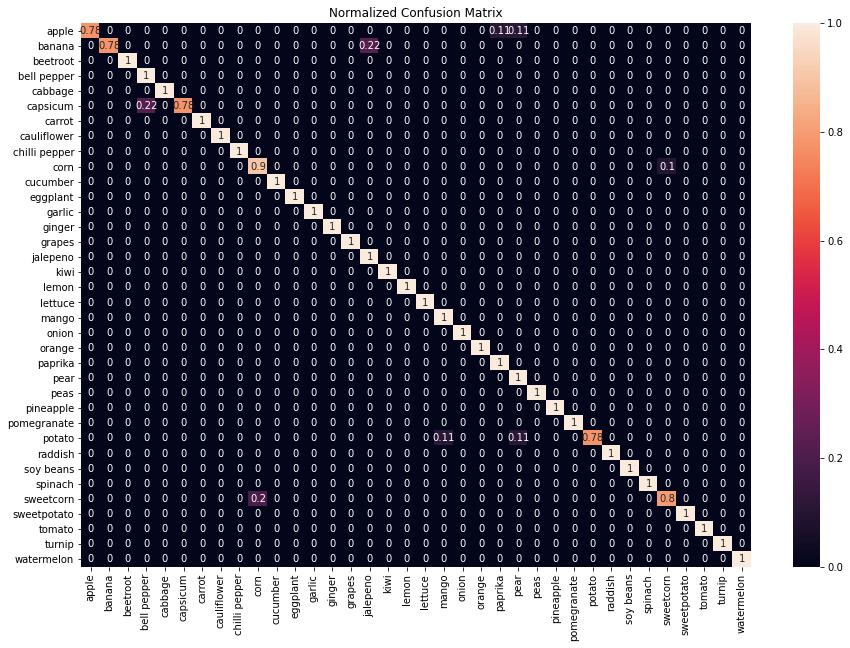

In [226]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns
cf_matrix = confusion_matrix(y_test, pred, normalize='true')  
plt.figure(figsize=(15,10))
sns.heatmap(cf_matrix, annot=True,
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test))
           )
plt.title('Normalized Confusion Matrix')
plt.show()

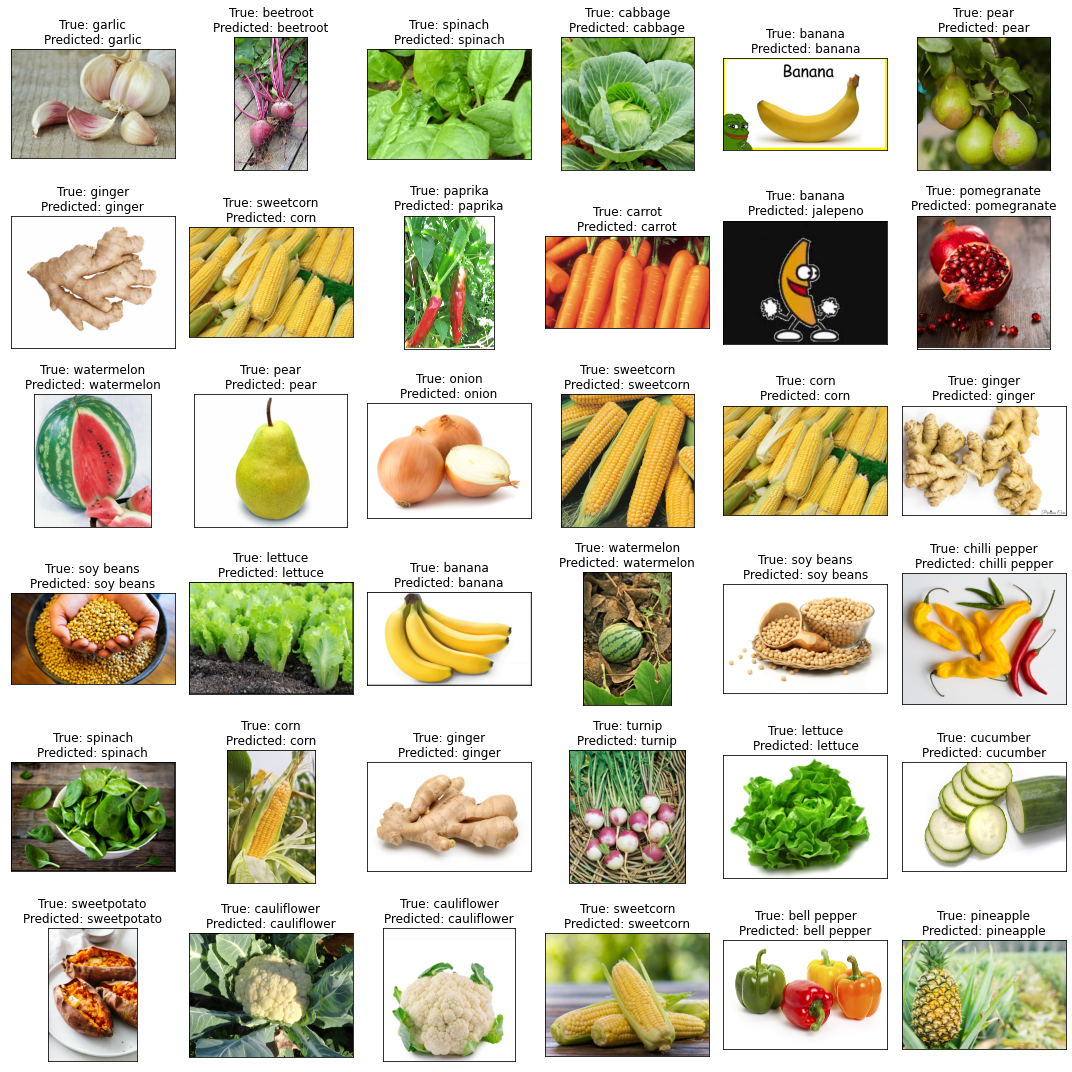

In [288]:
fig, axes = plt.subplots(6,6,figsize=(15,15), subplot_kw={'xticks': [], 'yticks': []}) 

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.FilePath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [229]:
model.save('fruits_vegetables2.h5')

In [289]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [290]:
train_dir = './dataset/train'
val_dir = './dataset/validation'
test_dir = './dataset/test'
classes0 = os.listdir(train_dir)
classes=sorted(classes0)

['.DS_Store', 'apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


In [291]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(40),              # resize shortest side
        transforms.CenterCrop(40),          # crop longest side
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [292]:
trainset = ImageFolder(train_dir, transform=train_transform)
valset = ImageFolder(val_dir, transform=train_transform)
testset = ImageFolder(test_dir, transform=train_transform)
print(len(trainset))

3115


In [293]:
img, label = trainset[10]
print(img.shape)

torch.Size([3, 40, 40])


In [294]:
def show_image(img,label):
    print('Label: ', trainset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Label:  apple (0)
Label:  apple (0)


(None, None)

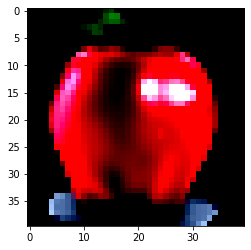

In [298]:
show_image(*trainset[0])

Label:  beetroot (2)


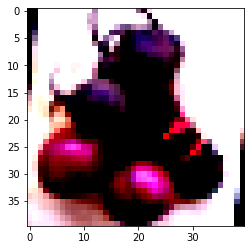

In [299]:
show_image(*trainset[200])

In [300]:
torch.manual_seed(10)
train_size = len(trainset)
val_size = len(valset)
test_size = len(testset)

In [301]:
train_ds=trainset
val_ds=valset
test_ds=testset
len(train_ds), len(val_ds), len(test_ds)   

(3115, 351, 360)

In [302]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

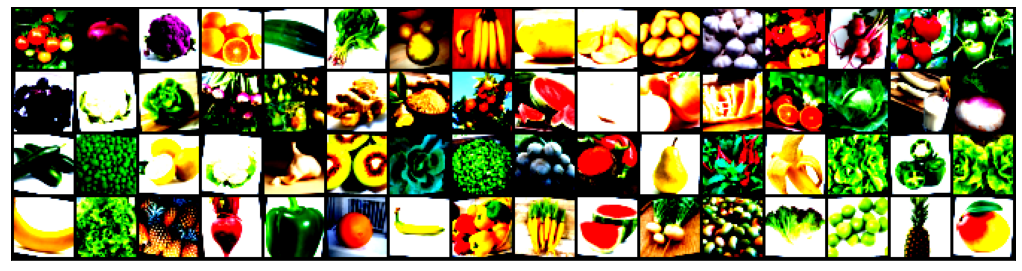

In [303]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break

In [304]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                   
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)          
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [305]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [306]:
torch.cuda.is_available()

False

In [307]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [308]:
device = get_default_device()
device

device(type='cpu')

In [309]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [310]:
input_size = 3*40*40
output_size = 3

In [311]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                   
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels) 
        acc = accuracy(out, labels)         
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()    
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [312]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(6250, 256),  
            nn.ReLU(),            
            nn.Linear(256, 128),  
            nn.ReLU(),            
            nn.Linear(128, 64),           
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(32, len(classes)))
        
    def forward(self, xb):
        return self.network(xb)

In [313]:
model = CnnModel()

In [314]:
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=6250, out_features=256, bias=True)
    (17): ReLU()
    (18): Linear(in_features

In [315]:
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 40, 40])
out.shape: torch.Size([64, 37])
out[0]: tensor([ 0.0343, -0.0284, -0.1118, -0.0235, -0.0149, -0.0870, -0.2117, -0.0293,
         0.1733,  0.1238, -0.0209,  0.0750,  0.1252,  0.0203,  0.0774,  0.1211,
        -0.1287,  0.1469,  0.0421,  0.0483,  0.0718, -0.0137, -0.1873,  0.0558,
        -0.0936, -0.1361, -0.1709,  0.0690, -0.0959,  0.1600,  0.1192,  0.0172,
         0.0748,  0.0792, -0.0845,  0.1159,  0.0860],
       grad_fn=<SelectBackward0>)


In [316]:
device = get_default_device()
device

device(type='cpu')

In [317]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)
to_device(model, device)

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=6250, out_features=256, bias=True)
    (17): ReLU()
    (18): Linear(in_features

In [318]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [319]:
model = to_device(CnnModel(), device)

In [320]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 3.6167774200439453, 'val_acc': 0.035087719559669495}]

In [323]:
num_epochs = 75
opt_func = torch.optim.Adam
lr = 0.001

In [324]:
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 3.4558, val_loss: 3.3139, val_acc: 0.0713



Epoch [1], train_loss: 3.3298, val_loss: 3.1774, val_acc: 0.0625



Epoch [2], train_loss: 3.2501, val_loss: 3.0886, val_acc: 0.0790



Epoch [3], train_loss: 3.2003, val_loss: 3.0222, val_acc: 0.1020



Epoch [4], train_loss: 3.1248, val_loss: 2.9328, val_acc: 0.1182



Epoch [5], train_loss: 3.0302, val_loss: 2.7778, val_acc: 0.1125



Epoch [6], train_loss: 2.9610, val_loss: 2.7012, val_acc: 0.1449



Epoch [7], train_loss: 2.8555, val_loss: 2.4235, val_acc: 0.2100



Epoch [8], train_loss: 2.7342, val_loss: 2.3157, val_acc: 0.2373



Epoch [9], train_loss: 2.6381, val_loss: 2.1420, val_acc: 0.2784



Epoch [10], train_loss: 2.5641, val_loss: 2.1072, val_acc: 0.2732



Epoch [11], train_loss: 2.4750, val_loss: 1.9510, val_acc: 0.3239



Epoch [12], train_loss: 2.4672, val_loss: 2.0011, val_acc: 0.3055



Epoch [13], train_loss: 2.3986, val_loss: 1.9862, val_acc: 0.3397



Epoch [14], train_loss: 2.3280, val_loss: 1.8055, val_acc: 0.3899



Epoch [15], train_loss: 2.3011, val_loss: 1.7926, val_acc: 0.4035



Epoch [16], train_loss: 2.2533, val_loss: 1.7168, val_acc: 0.4415



Epoch [17], train_loss: 2.1887, val_loss: 1.6797, val_acc: 0.4397



Epoch [18], train_loss: 2.1547, val_loss: 1.6396, val_acc: 0.4747



Epoch [19], train_loss: 2.1161, val_loss: 1.6676, val_acc: 0.4291



Epoch [20], train_loss: 2.0858, val_loss: 1.5737, val_acc: 0.4771



Epoch [21], train_loss: 2.0468, val_loss: 1.5524, val_acc: 0.4425



Epoch [22], train_loss: 1.9947, val_loss: 1.5159, val_acc: 0.4988



Epoch [23], train_loss: 1.9794, val_loss: 1.3767, val_acc: 0.5912



Epoch [24], train_loss: 1.9221, val_loss: 1.4749, val_acc: 0.4850



Epoch [25], train_loss: 1.9137, val_loss: 1.3161, val_acc: 0.5503



Epoch [26], train_loss: 1.8447, val_loss: 1.3437, val_acc: 0.5212



Epoch [27], train_loss: 1.8428, val_loss: 1.3333, val_acc: 0.5562



Epoch [28], train_loss: 1.7850, val_loss: 1.3103, val_acc: 0.5627



Epoch [29], train_loss: 1.7622, val_loss: 1.1301, val_acc: 0.6236



Epoch [30], train_loss: 1.6859, val_loss: 1.2230, val_acc: 0.6463



Epoch [31], train_loss: 1.6458, val_loss: 1.1708, val_acc: 0.6367



Epoch [32], train_loss: 1.6106, val_loss: 1.0751, val_acc: 0.6506



Epoch [33], train_loss: 1.5532, val_loss: 1.1237, val_acc: 0.6420



Epoch [34], train_loss: 1.6037, val_loss: 1.1335, val_acc: 0.6213



Epoch [35], train_loss: 1.5786, val_loss: 1.0856, val_acc: 0.6454



Epoch [36], train_loss: 1.4736, val_loss: 0.9813, val_acc: 0.6591



Epoch [37], train_loss: 1.4698, val_loss: 0.9563, val_acc: 0.6822



Epoch [38], train_loss: 1.3918, val_loss: 0.9895, val_acc: 0.6489



Epoch [39], train_loss: 1.3885, val_loss: 0.9418, val_acc: 0.7083



Epoch [40], train_loss: 1.3067, val_loss: 0.8891, val_acc: 0.7083



Epoch [41], train_loss: 1.3320, val_loss: 0.8373, val_acc: 0.7361



Epoch [42], train_loss: 1.2909, val_loss: 0.7714, val_acc: 0.7447



Epoch [43], train_loss: 1.2899, val_loss: 0.8063, val_acc: 0.7718



Epoch [44], train_loss: 1.2160, val_loss: 0.6432, val_acc: 0.7806



Epoch [45], train_loss: 1.1982, val_loss: 0.7355, val_acc: 0.7743



Epoch [46], train_loss: 1.1905, val_loss: 0.7150, val_acc: 0.7883



Epoch [47], train_loss: 1.1042, val_loss: 0.6717, val_acc: 0.7892



Epoch [48], train_loss: 1.0947, val_loss: 0.7042, val_acc: 0.7849



Epoch [49], train_loss: 1.0441, val_loss: 0.6730, val_acc: 0.8084



Epoch [50], train_loss: 0.9970, val_loss: 0.6852, val_acc: 0.8058



Epoch [51], train_loss: 1.0077, val_loss: 0.5757, val_acc: 0.8276



Epoch [52], train_loss: 0.9644, val_loss: 0.5027, val_acc: 0.8712



Epoch [53], train_loss: 0.9094, val_loss: 0.5796, val_acc: 0.8571



Epoch [54], train_loss: 0.9186, val_loss: 0.5376, val_acc: 0.8520



Epoch [55], train_loss: 0.9456, val_loss: 0.6601, val_acc: 0.7790



Epoch [56], train_loss: 0.9046, val_loss: 0.5662, val_acc: 0.8109



Epoch [57], train_loss: 0.8735, val_loss: 0.7845, val_acc: 0.7770



Epoch [58], train_loss: 0.8513, val_loss: 0.5281, val_acc: 0.8590



Epoch [59], train_loss: 0.8076, val_loss: 0.5731, val_acc: 0.8120



Epoch [60], train_loss: 0.8738, val_loss: 0.5608, val_acc: 0.8414



Epoch [61], train_loss: 0.7132, val_loss: 0.4410, val_acc: 0.8843



Epoch [62], train_loss: 0.7543, val_loss: 0.4681, val_acc: 0.8756



Epoch [63], train_loss: 0.7661, val_loss: 0.5309, val_acc: 0.8712



Epoch [64], train_loss: 0.7268, val_loss: 0.5217, val_acc: 0.8720



Epoch [65], train_loss: 0.7385, val_loss: 0.5500, val_acc: 0.8233



Epoch [66], train_loss: 0.7417, val_loss: 0.5682, val_acc: 0.8835



Epoch [67], train_loss: 0.7163, val_loss: 0.4514, val_acc: 0.8730



Epoch [68], train_loss: 0.6813, val_loss: 0.4893, val_acc: 0.8921



Epoch [69], train_loss: 0.6193, val_loss: 0.6166, val_acc: 0.8276



Epoch [70], train_loss: 0.6344, val_loss: 0.5994, val_acc: 0.8536



Epoch [71], train_loss: 0.6114, val_loss: 0.4722, val_acc: 0.8910



Epoch [72], train_loss: 0.6503, val_loss: 0.5842, val_acc: 0.8764



Epoch [73], train_loss: 0.5874, val_loss: 0.5133, val_acc: 0.8747



Epoch [74], train_loss: 0.6197, val_loss: 0.4976, val_acc: 0.8964


In [325]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

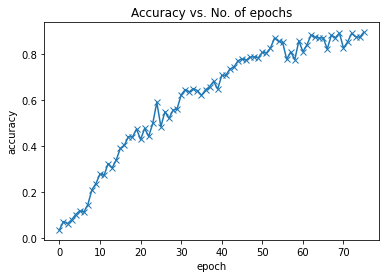

In [326]:
plot_accuracies(history)

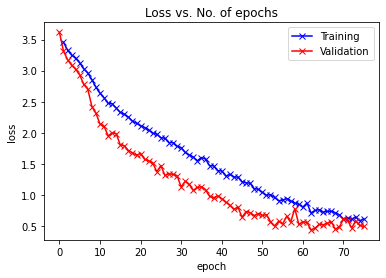

In [327]:
plot_losses(history)

In [328]:
evaluate(model, test_loader)

{'val_loss': 0.46558189392089844, 'val_acc': 0.9052484035491943}

In [332]:
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [339]:
len(test_images)

104

In [343]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred,target_names=classes,digits=4))

               precision    recall  f1-score   support

        apple     1.0000    0.6000    0.7500        10
       banana     0.7778    0.7000    0.7368        10
     beetroot     1.0000    1.0000    1.0000        10
  bell pepper     0.8571    0.6000    0.7059        10
      cabbage     1.0000    1.0000    1.0000        10
     capsicum     0.7143    1.0000    0.8333        10
       carrot     1.0000    0.9000    0.9474        10
  cauliflower     1.0000    1.0000    1.0000        10
chilli pepper     1.0000    1.0000    1.0000        10
         corn     1.0000    0.1000    0.1818        10
     cucumber     0.9091    1.0000    0.9524        10
     eggplant     1.0000    1.0000    1.0000        10
       garlic     1.0000    1.0000    1.0000        10
       ginger     0.9000    0.9000    0.9000        10
       grapes     1.0000    1.0000    1.0000        10
     jalepeno     1.0000    0.8000    0.8889        10
         kiwi     1.0000    0.9000    0.9474        10
        l

In [376]:
torch.save(model, 'model.pth')